In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import spikingjelly.clock_driven as cd
import spikingjelly.datasets as sjds
# from spikingjelly.clock_driven import neuron, encoding, functional, layer, surrogate
from spikingjelly.activation_based import neuron, layer, learning

import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT

In [480]:
def generate_sound_wave(batch_size=32, num_samples=1.0, sample_rate=44100, 
                        frequencies=[440, 880], amplitudes=[1.0, 0.5],phase_shifts=[0,0],
                        harmonics=1):
    t = np.linspace(0, num_samples/sample_rate, num_samples, endpoint=False)
    # waves = np.zeros_like(batch_size,t)
    waves = np.zeros((batch_size, *t.shape))

    for freq, amp , phase in zip(frequencies, amplitudes, phase_shifts):
        waves += amp * np.cos(2 * np.pi * freq * t + phase)
        for i in range(1, harmonics + 1):
            adj_amp = amp / i
            harmonic_freq = freq * i
            waves += adj_amp * np.sin(2 * np.pi * harmonic_freq * t)

    return waves, t

def get_fourier_transform(wave, sample_rate):
    N = len(wave)
    T = 1.0 / sample_rate

    yf = scipy.fftpack.fft(wave)
    xf = np.linspace(0.0,   1.0 / (2.0 * T), N // 2) # Nyquist frequency F/2 = 1/(2*T
    amplitudes = 2.0 / N * np.abs(yf[:N // 2])
    phases = np.angle(yf[:N // 2])

    return xf, amplitudes, phases

def get_fourier_transform_batch(waves, sample_rate):
    batch_size, N = waves.shape
    T = 1.0 / sample_rate

    yf = scipy.fftpack.fft(waves, axis=1)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)  # Nyquist frequency F/2 = 1/(2*T)
    amplitudes = 2.0 / N * np.abs(yf[:, :N // 2])
    phases = np.angle(yf[:, :N // 2])

    return xf, amplitudes, phases
    
def poisson_spike_encoding(amplitudes, duration, sample_rate):
    num_neurons = len(amplitudes)
    num_samples = int(duration * sample_rate)
    # spike_trains = np.zeros((num_neurons, num_samples))

    scale = 1 
    spik_probs = amplitudes / np.max(amplitudes, axis=0) * scale

    spike_trains = np.random.poisson(spik_probs[..., np.newaxis] * duration, (num_neurons, num_samples))
    spike_trains = np.clip(spike_trains, 0, 1)

    return spike_trains

def poisson_spike_encoding_batch(amplitudes, duration, sample_rate):
    batch_size, num_neurons = amplitudes.shape
    num_samples = int(duration * sample_rate)

    # Normalize amplitudes to [0, 1] for probability calculation
    scale = 1 
    spik_probs = amplitudes / np.max(amplitudes, axis=1, keepdims=True) * scale

    # Generate Poisson-distributed spikes for the entire batch
    spike_trains = np.random.poisson(spik_probs[..., np.newaxis] * duration, size=(batch_size, num_neurons, num_samples))
    
    # Clip spike trains to binary values (0 or 1)
    spike_trains = np.clip(spike_trains, 0, 1)

    return spike_trains

# encode spectrogram in spikes
def range_selectivity_spike_encoding(spectrogram, num_encoding_neurons, kernel, spike_prob_scale=1):
    # Apply the convolution
    spectrogram_conv = convolve1d(spectrogram, weights=kernel, axis=0, mode='constant')
    # normalize it to [0, 1]
    spectrogram_conv = (spectrogram_conv - np.min(spectrogram_conv)) / (np.max(spectrogram_conv) - np.min(spectrogram_conv))

    # spread the encoding neurons across the frequency range of the spectrogram
    # such that each neuron has a selectivity to a range of frequencies
    num_freqs, num_samples = spectrogram.shape
    freq_centers = np.linspace(1, num_freqs, num_encoding_neurons, endpoint=False, dtype=int)

    spectrogram_conv *= spike_prob_scale

    spike_trains = np.random.poisson(spectrogram_conv[freq_centers, :], size=(num_encoding_neurons, num_samples))
    spike_trains = np.clip(spike_trains, 0, 1)
    
    return spike_trains, freq_centers

def range_selectivity_spike_encoding_batch(spectrograms, num_encoding_neurons, kernel, spike_prob_scale=1):
    batch_size, num_freqs, num_samples = spectrograms.shape
    spike_trains = np.zeros((batch_size, num_encoding_neurons, num_samples))
    freq_centers = None
    for i in range(batch_size):
        spike_trains[i], freq_centers = range_selectivity_spike_encoding(spectrograms[i], num_encoding_neurons, kernel, spike_prob_scale)
    return spike_trains , freq_centers  

def plot_spectrogram(spgram, SFT, wave, t, num_samples, title):
    # Plot the spectrogram
    plt.figure(figsize=(12, 10))
    # plot the wave
    plt.subplot(2,1,1)
    plt.plot(t, wave)
    plt.title('Generated Sound Wave')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    # plot the spectrogram
    plt.subplot(2,1,2)
    Sx_dB = 10 * np.log10(np.fmax(spgram, 1e-3))  # limit range to -40 dB
    t_low, t_high = SFT.extent(num_samples)[:2]
    print(SFT.extent(num_samples))
    plt.imshow(Sx_dB, aspect='auto', origin='lower', cmap='magma', extent=SFT.extent(num_samples))
    # plt.title('Spectrogram')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Frequency [Hz]')
    plt.title(rf"Spectrogram ({SFT.m_num*SFT.T:g}$\,s$ Gaussian " +
                rf"window, $\sigma_t={g_std*SFT.T:g}\,$s)")
    plt.xlabel(f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
                rf"$\Delta t = {SFT.delta_t:g}\,$s)")
    plt.ylabel(f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
                rf"$\Delta f = {SFT.delta_f:g}\,$Hz)")

    # mark signal borders with vertical lines
    for t_ in [0, num_samples * SFT.T]:  
        plt.axvline(t_, color='g', linestyle='--', alpha=0.5)

    plt.colorbar(orientation='vertical', label='Power Spectral Density in dB')
    plt.tight_layout()
    plt.show()

# Generating Surrogate sound Data / Exploration

(32, 1000) (32, 1000)
(32, 1001, 519) float64
(-0.018000000000000002, 1.02, 0.0, 500.5)


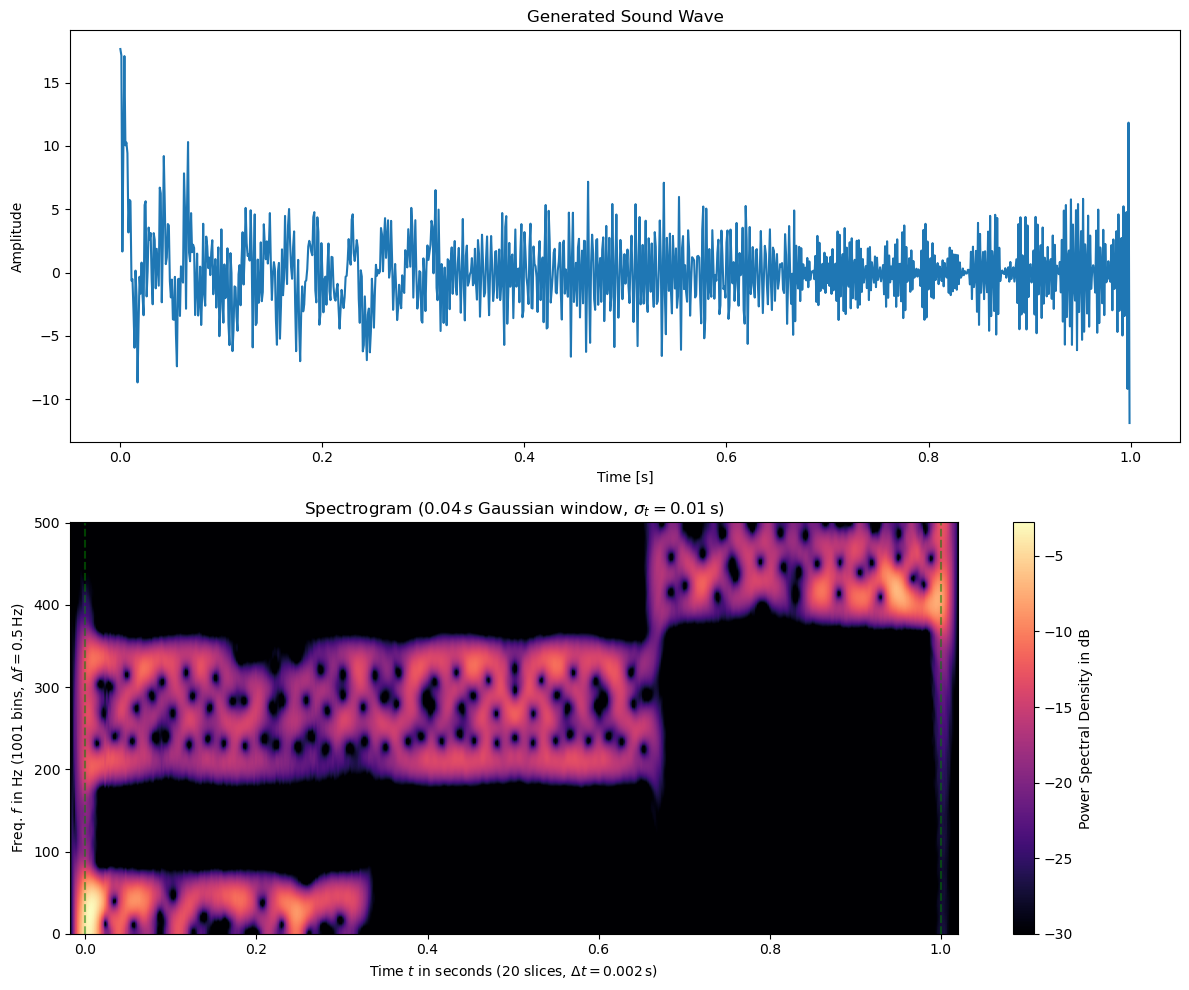

(-0.018000000000000002, 1.02, 0.0, 500.5)


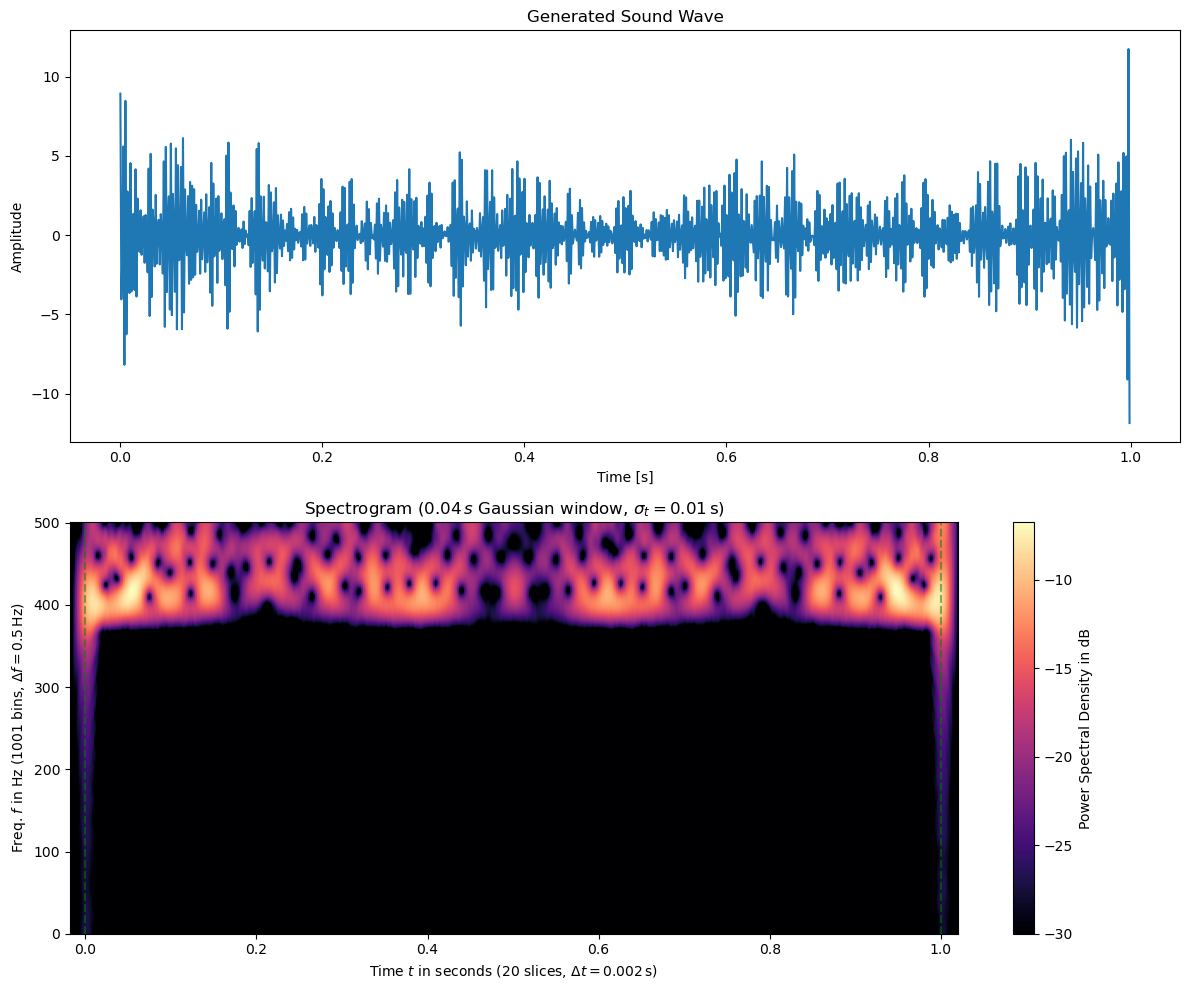

In [481]:
batch_size = 32
sample_rate = 1000 # f = 1 / T
num_samples = 1000

duration = num_samples / sample_rate
wave_period = 1/sample_rate

num_freqs = 20
frequencies = np.random.randint(200, 350, size=num_freqs)
amplitudes = np.random.rand(num_freqs)
# amplitudes = np.ones(num_freqs)
phase_shifts = np.zeros(num_freqs)
harmonics = 1

waves, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                               frequencies=frequencies, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

frequencies_1 = np.random.randint(1, 50, size=num_freqs)
waves_1, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                                 frequencies=frequencies_1, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

frequencies_2 = np.random.randint(400, 500, size=num_freqs)
waves_2, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                                    frequencies=frequencies_2, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

# construct a randomlly mixed waves batched by adding the waves together in a random order
# collect num_samples samples from the 3 waves in consecutive order
waves_mix = waves.copy()
waves_mix[:, :num_samples//3] += waves_1[:, :num_samples//3]
waves_mix[:, 2*num_samples//3:] = waves_2[:, 2*num_samples//3:]
# add some noise
waves_mix += np.random.normal(0, 0.1, waves_mix.shape)

print(waves.shape, waves_mix.shape)
sample_wave = waves_mix[0]

g_std = 10      # standard deviation for Gaussian window in samples
win_size = 40   # window size in samples
win_gauss = gaussian(win_size, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win_gauss, hop=2, fs=sample_rate, mfft=2000, scale_to='psd')
# SFT = ShortTimeFFT(win, hop=2, fs=sample_rate, scale_to='psd')

spgrams_1 = SFT.spectrogram(waves_mix)  # calculate absolute square of STFT
waves_2 += np.random.normal(0, 0.1, waves_2.shape)
spgrams_2 = SFT.spectrogram(waves_2)

print(spgrams_1.shape, spgrams_1.dtype)

spgrams_1_sample = SFT.spectrogram(sample_wave)
spgrams_2_sample = spgrams_2[0]

plot_spectrogram(spgrams_1_sample, SFT, sample_wave, t, num_samples, 'Spectrogram 1')
plot_spectrogram(spgrams_2_sample, SFT, waves_2[0], t, num_samples, 'Spectrogram 2')

In [507]:
num_encoding_neurons = 50
spike_prob_scale = 1.5

kerel_size = 200
tau = 50
g_std = 20

# kernel = exponential(kerel_size, tau=tau, sym=True)
# kernel = gaussian(kerel_size, std=g_std, sym=True)
# combined filter
k_gauss = gaussian(kerel_size, std=g_std, sym=True)
k_exp = exponential(kerel_size, tau=tau, sym=True)
kernel = k_gauss + k_exp
kernel /= np.max(kernel)

spike_trains_1, freq_centers = range_selectivity_spike_encoding_batch(spgrams_1, num_encoding_neurons=num_encoding_neurons,
                                                                      kernel=kernel, spike_prob_scale=spike_prob_scale)
spike_trains_2, freq_centers = range_selectivity_spike_encoding_batch(spgrams_2, num_encoding_neurons=num_encoding_neurons,
                                                                      kernel=kernel, spike_prob_scale=spike_prob_scale)

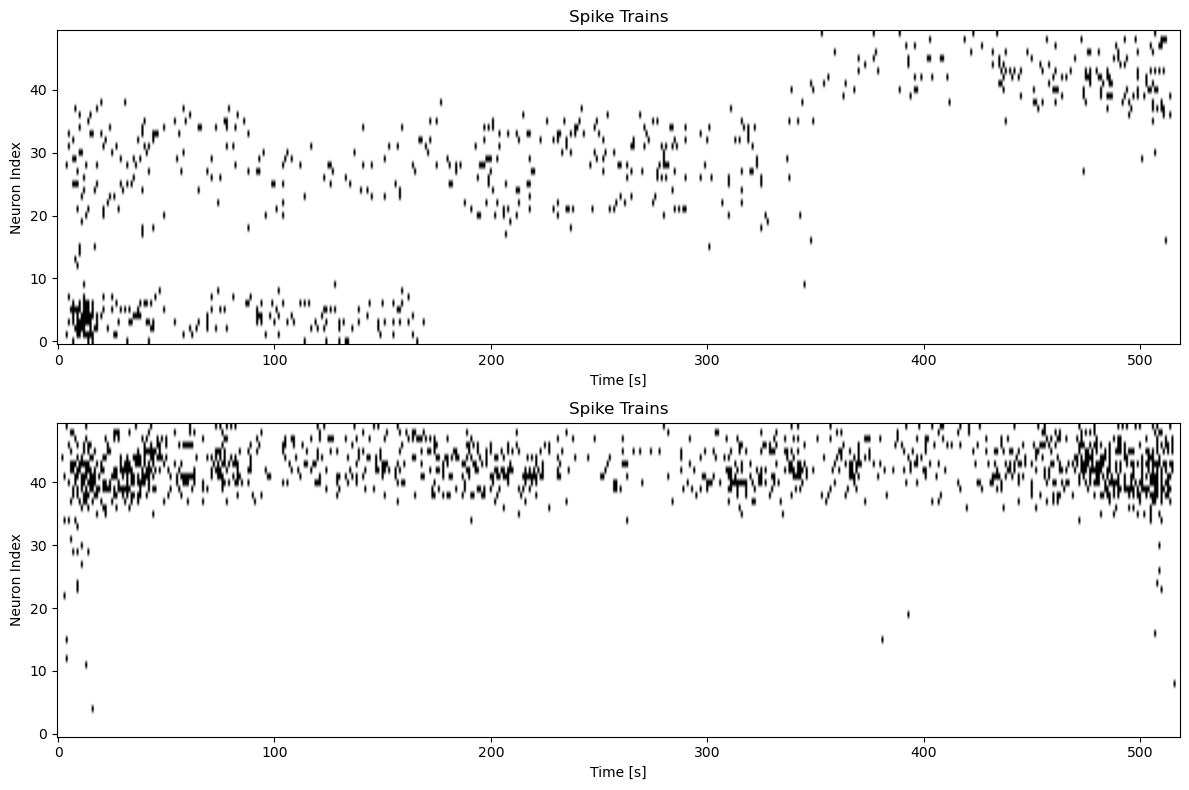

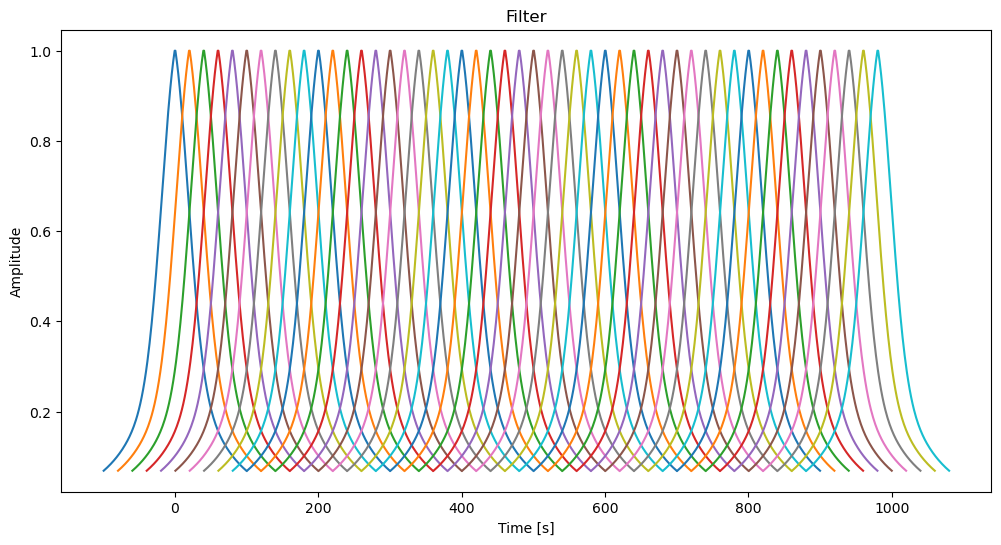

In [519]:
spike_trains_sample_1 = spike_trains_1[0]
spike_trains_sample_2 = spike_trains_2[0]

# Plot the spike trains
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.imshow(spike_trains_sample_1, aspect='auto', origin='lower', cmap='binary')
plt.title('Spike Trains')
plt.xlabel('Time [s]')
plt.ylabel('Neuron Index')

plt.subplot(2,1,2)
plt.imshow(spike_trains_sample_2, aspect='auto', origin='lower', cmap='binary')
plt.title('Spike Trains')
plt.xlabel('Time [s]')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()



# Plot the filter
kernels_xs = []
x_coords = np.arange(kerel_size)
for c in freq_centers:
    k_x = x_coords - (kerel_size/2) + c
    kernels_xs.append(k_x)

plt.figure(figsize=(12, 6))
for k_x in kernels_xs:
    plt.plot(k_x, kernel)
plt.title('Filter')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# SNN - sample STDP

In [518]:
EPOCHS = 10
batch_size = 32
nb_inputs = 50
nb_hidden = 100
nb_out = 2

dtype = torch.float
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")


# stdp params
tau_pre = 2.
tau_post = 2.
T = 128
N = 1
lr = 0.01

spike_trains_all = np.concatenate((spike_trains_1, spike_trains_2), axis=0)
labels = np.concatenate((np.zeros(batch_size), np.ones(batch_size)))

# Convert to PyTorch tensors
spike_trains_all = torch.tensor(spike_trains_all, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# print shape of spike_trains and labels
print('spike_trains shape:', spike_trains_all.shape)
print('labels shape:', labels.shape)

# Create DataLoader
dataset = TensorDataset(spike_trains_all, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


def f_weight(x):
    return torch.clamp(x, -1, 1.)

net = nn.Sequential(
   layer.Linear(nb_inputs , nb_hidden, bias=False),
   neuron.IFNode(),
   layer.Linear(nb_hidden, nb_out, bias=False),
   neuron.IFNode(),
)

weight_scale = 0.2
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
w2 = torch.empty((nb_hidden, nb_out),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Define the STDP learning rule
stdp = learning.STDPLearner(step_mode='s', synapse=net[0], sn=net[1], tau_pre=tau_pre, tau_post=tau_post,
                                    f_pre=f_weight, f_post=f_weight)
stdp_out = learning.STDPLearner(step_mode='s', synapse=net[2], sn=net[3], tau_pre=tau_pre, tau_post=tau_post,
                                    f_pre=f_weight, f_post=f_weight)
# Define the optimizer
# optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

out_spike = []
trace_pre = []
trace_post = []
trace_pre_out = []
trace_post_out = []
weight_1 = []
weight_2 = []

for epoch in range(EPOCHS):
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            # inputs = inputs.view(batch_size, -1)  # Flatten the inputs
            optimizer.zero_grad()
            for t in range(inputs.shape[-1]):
                out_spike.append(net(inputs[:,:,t]).squeeze())
                stdp.step(on_grad=True)  # Add ``- delta_w * scale`` on grad
                stdp_out.step(on_grad=True)  # Add ``- delta_w * scale`` on grad
                optimizer.step()
                weight_1.append(net[0].weight.data.clone().squeeze())
                weight_2.append(net[2].weight.data.clone().squeeze())
                trace_pre.append(stdp.trace_pre.squeeze())
                trace_post.append(stdp.trace_post.squeeze())
                trace_pre_out.append(stdp_out.trace_pre.squeeze())
                trace_post_out.append(stdp_out.trace_post.squeeze())

in_spikes = spike_trains_1.squeeze()
out_spike = torch.stack(out_spike)
trace_pre = torch.stack(trace_pre)
trace_post = torch.stack(trace_post)
trace_pre_out = torch.stack(trace_pre_out)
trace_post_out = torch.stack(trace_post_out)
weight_1 = torch.stack(weight_1)
weight_2 = torch.stack(weight_2)

spike_trains shape: torch.Size([64, 50, 519])
labels shape: torch.Size([64])


In [510]:
print('in_spikes shape:', in_spikes.shape)
print('out_spike shape:', out_spike.shape)
print('trace_pre shape:', trace_pre.shape)
print('trace_post shape:', trace_post.shape)
print('weight shape:', weight_1.shape)
print('weight shape:', weight_2.shape)

in_spikes shape: (32, 50, 519)
out_spike shape: torch.Size([10380, 32, 2])
trace_pre shape: torch.Size([10380, 32, 50])
trace_post shape: torch.Size([10380, 32, 100])
weight shape: torch.Size([10380, 100, 50])
weight shape: torch.Size([10380, 2, 100])


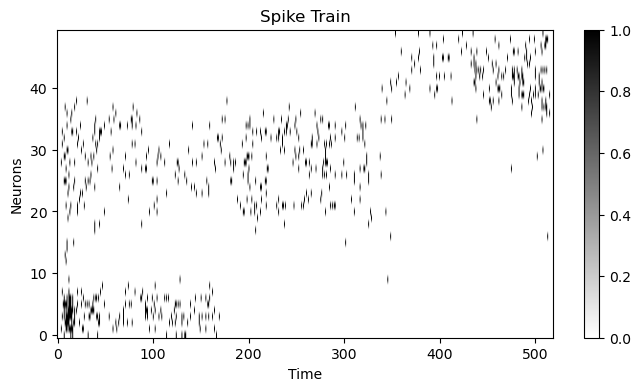

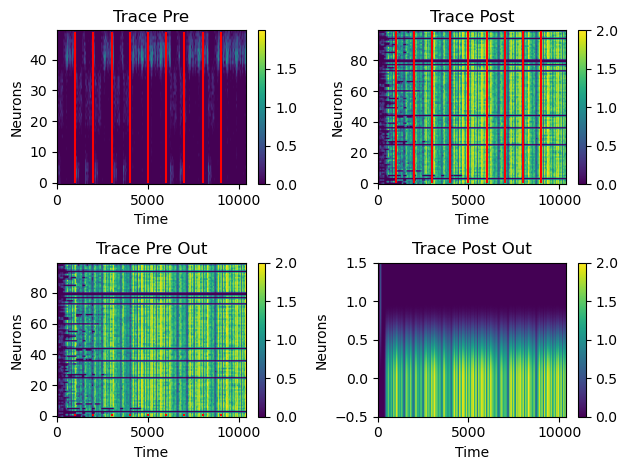

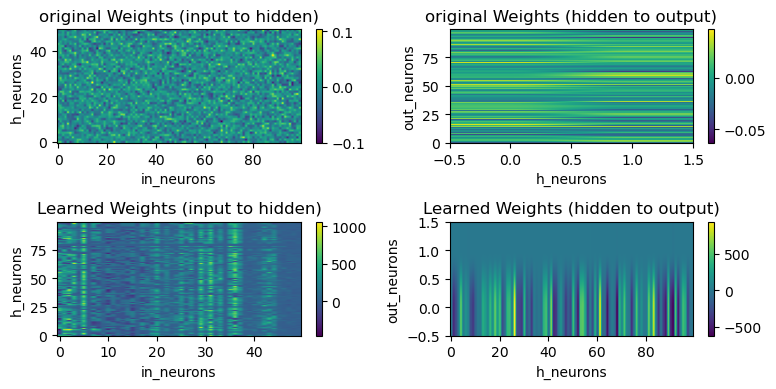

In [517]:
batch = 0

plt.figure(figsize=(8, 4))
plt.imshow(spike_trains_1[0,:,:], aspect='auto', origin='lower', cmap='binary')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Spike Train')
plt.colorbar()
plt.show()

plt.subplot(2,2,1)
plt.imshow(trace_pre[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Pre')
plt.colorbar()
# added vertical lines seperating epoches
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_inputs-1, color='r')

plt.subplot(2,2,2)
plt.imshow(trace_post[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Post')
plt.colorbar()
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_hidden-1, color='r')

plt.subplot(2,2,3)
plt.imshow(trace_pre_out[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Pre Out')
plt.colorbar()
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_out-1, color='r')

plt.subplot(2,2,4)
plt.imshow(trace_post_out[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Post Out')
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(2,2,1)
plt.imshow(w1.detach(), aspect='auto', origin='lower')
plt.xlabel('in_neurons')
plt.ylabel('h_neurons')
plt.title('original Weights (input to hidden)')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(w2.detach(), aspect='auto', origin='lower')
plt.xlabel('h_neurons')
plt.ylabel('out_neurons')
plt.title('original Weights (hidden to output)')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(weight_1[-1], aspect='auto', origin='lower')
plt.xlabel('in_neurons')
plt.ylabel('h_neurons')
plt.title('Learned Weights (input to hidden)')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(weight_2[-1], aspect='auto', origin='lower')
plt.xlabel('h_neurons')
plt.ylabel('out_neurons')
plt.title('Learned Weights (hidden to output)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Read Out Layer (TODO)

43.212300949373564


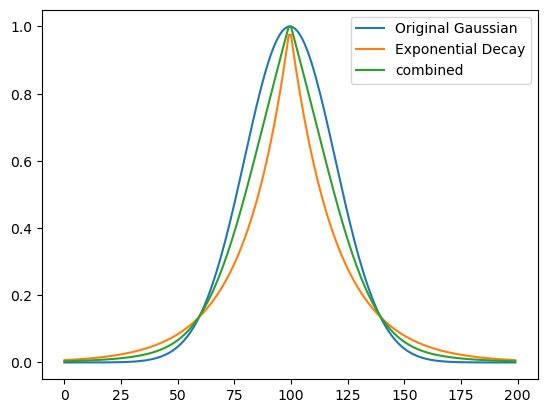

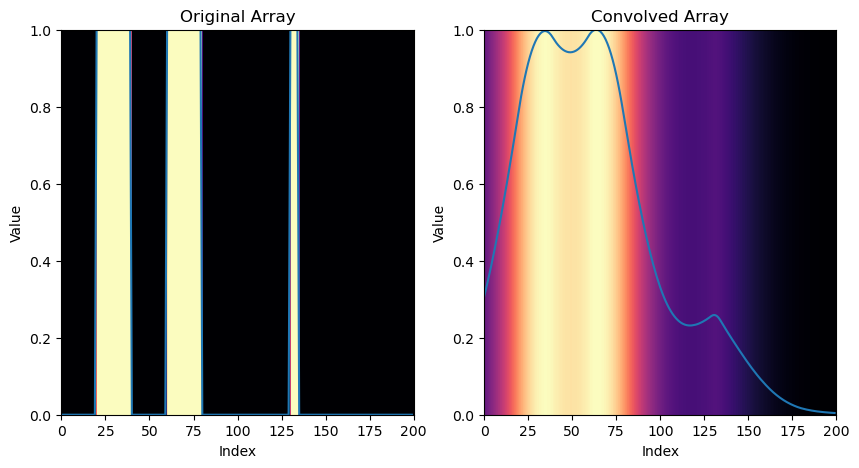

In [521]:
from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential

num_enconding_neurons = 20

win_size = 200
g_std = 20
decay_rate = 50  # rate of exponential decay
tau = -(win_size-1) / np.log(0.01)
print(tau)

# Gaussian filter
win_gauss = gaussian(win_size, std=g_std, sym=True)
# exponential decay filter
win_exponential = exponential(win_size, tau=g_std, sym=True)
# combined filter
win_combined = win_gauss + win_exponential
win_combined /= np.max(win_combined)

plt.plot(win_gauss, label='Original Gaussian')
plt.plot(win_exponential, label='Exponential Decay')
plt.plot(win_combined, label='combined')
plt.legend()
plt.show()


test_arr = np.zeros(200)
test_arr[20:40] = 1
test_arr[60:80] = 1
test_arr[130:135] = 1
# Sx2 = np.convolve(Sx2.flatten(), win, mode='same')
test_arr_conv = convolve1d(test_arr, weights=win_combined, mode='constant')

# normalize the convolved spectrogram, it has negative values
test_arr_conv = test_arr_conv / np.max(test_arr_conv)



plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(test_arr)
plt.imshow(test_arr.reshape(1, -1), aspect='auto', origin='lower', cmap='magma', extent=[0, win_size, 0, 1])
plt.title('Original Array')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1,2,2)
plt.plot(test_arr_conv)
plt.imshow(test_arr_conv.reshape(1, -1), aspect='auto', origin='lower', cmap='magma', extent=[0, win_size, 0, 1])
plt.title('Convolved Array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


(32, 1000)
xf: (500,)
amplitudes: (500,)
phases: (500,)
prominent frequencies: [201.40280561 202.40480962 203.40681363 219.43887776 225.4509018
 238.47695391 255.51102204 262.5250501  268.53707415 283.56713427
 308.61723447 310.62124248 313.62725451 338.67735471 339.67935872
 344.68937876 346.69338677 348.69739479]
prominent amplitudes: [1.39983122 1.27012016 0.60011853 1.29019757 1.24859355 0.1656709
 1.1506423  1.32358936 1.13439483 0.95389844 1.13003862 0.21007953
 0.68075393 0.64420588 0.8404237  0.19634616 1.26539327 0.98168629]
prominent phases: [-0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816
 -0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816
 -0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816 -0.78539816]


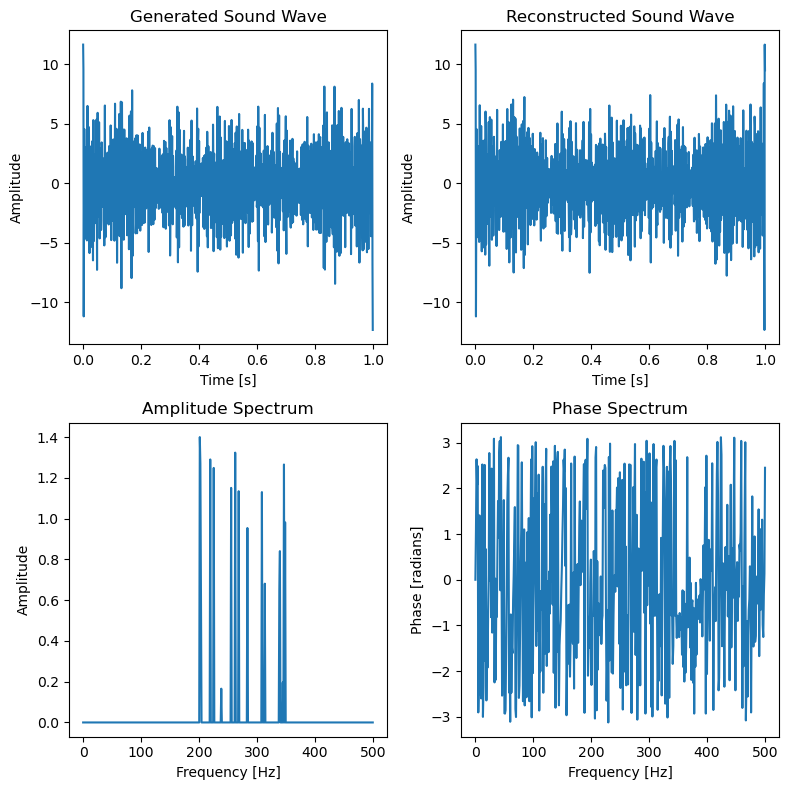

In [523]:
batch_size = 32
sample_rate = 1000 # f = 1 / T
num_samples = 1000

duration = num_samples / sample_rate
wave_period = 1/sample_rate

num_freqs = 20
frequencies = np.random.randint(200, 350, size=num_freqs)
amplitudes = np.random.rand(num_freqs)
# amplitudes = np.ones(num_freqs)
phase_shifts = np.zeros(num_freqs)
harmonics = 1

waves, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                               frequencies=frequencies, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)
print(waves.shape)
wave = waves[0]

# Plot the generated sound wave
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(t, wave)
plt.title('Generated Sound Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


# Get Fourier Transform and plot amplitude and phase
xf_1, amplitudes, phases_1 = get_fourier_transform(wave, sample_rate=sample_rate)
# print shapes
print('xf:', xf_1.shape)
print('amplitudes:', amplitudes.shape)
print('phases:', phases_1.shape)

# get the prominent frequencies 
amp_threshold = 0.1
prom_freqs = xf_1[amplitudes > amp_threshold]
# get the prominent amplitudes
prom_amps = amplitudes[amplitudes > amp_threshold]
# get the prominent phases
prom_phases = phases_1[amplitudes > amp_threshold]
print('prominent frequencies:', prom_freqs)
print('prominent amplitudes:', prom_amps)
print('prominent phases:', prom_phases)


# Plot the amplitude spectrum
plt.subplot(2, 2, 3)
plt.plot(xf_1, amplitudes)
plt.title('Amplitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Plot the phase spectrum
plt.subplot(2, 2, 4)
plt.plot(xf_1, phases_1)
plt.title('Phase Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')


# reconstruct the sound wave from the prominent frequencies
wave_reconstructed = np.zeros_like(wave)
for freq, amp, phase in zip(prom_freqs, prom_amps, prom_phases):
    wave_reconstructed += amp * np.cos(2 * np.pi * freq * t + phase)

plt.subplot(2, 2, 2)
plt.plot(t, wave_reconstructed)
plt.title('Reconstructed Sound Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# play audio

In [4]:
import sounddevice as sd

print(sd.query_devices())

# Print available sample rates for the default output device
device_info = sd.query_devices(kind='output')
print("Default Output Device Info:\n", device_info)

# Print the default sample rate
default_sample_rate = device_info['default_samplerate']
print("Default Sample Rate:", default_sample_rate)
sd.play(wave, sample_rate)
sd.wait()

> 0 HD-Audio Generic: ALC245 Analog (hw:1,0), ALSA (2 in, 0 out)
  1 acp: - (hw:2,0), ALSA (2 in, 0 out)
< 2 hdmi, ALSA (0 in, 8 out)
Default Output Device Info:
 {'name': 'hdmi', 'index': 2, 'hostapi': 0, 'max_input_channels': 0, 'max_output_channels': 8, 'default_low_input_latency': -1.0, 'default_low_output_latency': 0.005804988662131519, 'default_high_input_latency': -1.0, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0}
Default Sample Rate: 44100.0


In [5]:
import numpy as np
import sounddevice as sd

def generate_tone(frequency, duration=1.0, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave

def play_sound(wave, sample_rate):
    sd.play(wave, sample_rate)
    sd.wait()  # Wait until the sound has finished playing

# Generate and play tones at various frequencies within the audible range
frequencies = [50, 250, 1000, 5000, 10000, 15000]  # Hz

for freq in frequencies:
    wave = generate_tone(freq)
    print(f"Playing {freq} Hz tone...")
    play_sound(wave, 44100)

Playing 50 Hz tone...
Playing 250 Hz tone...
Playing 1000 Hz tone...
Playing 5000 Hz tone...
Playing 10000 Hz tone...
Playing 15000 Hz tone...
